In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# %tensorflow_version only exists in Colab.
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing

import os
import pathlib
import numpy as np
import pandas as pd
import IPython.display as display
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

from PIL import Image


print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__) 


#verbose = True   
verbose = False

TensorFlow 2.x selected.
Num GPUs Available:  1
Tensorflow version:  2.1.0


#Dataset Import and Overview

In [0]:
BATCH_SIZE = 128
IMG_HEIGHT = 331
IMG_WIDTH = 331

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
np.random.seed(101)
tf.random.set_seed(101)


LABELS_FILE = "/content/drive/My Drive/dogs/train_labels.csv"

df = pd.read_csv(LABELS_FILE)
print(df.head())

CLASS_NAMES = np.unique(df.breed)
class_count = len(CLASS_NAMES)

data_dir = "/content/drive/My Drive/dogs/Dataset/train"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

                                 id               breed
0  a32893132f6fbb3635df77c157c7d8e0  scottish_deerhound
1  3b3ae8c92f704bf449ea4bc61866461b  scottish_deerhound
2  c9bbc4ce586c0d73e14bee1b1e674ba9  scottish_deerhound
3  f194e48d99e5e0f279eb8cd5e6872e36  scottish_deerhound
4  03dc61595ad9dbf49e3998cf586ca8cb  scottish_deerhound
Number of images: 2205


#Image Loading

In [5]:
# Get a dataset of all files matching the pattern
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/content/drive/My Drive/dogs/Dataset/train/norwegian_elkhound/d9483ad58c5e1ae2e73ac0de09aac90d.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/border_terrier/5501faf6694477c31ea97dede096154c.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/lhasa/4b3f4c910479686b10d676f813da0b3f.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/beagle/58154ab6841198957a50526106c72d72.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/pembroke/4792cc9e614c5aa380ce532a2b182e16.jpg'


In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # the second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    return img

def process_path(file_path):
    label = get_label(file_path)
    # load raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label  

In [7]:
# apply process_path function to each element of this dataset, and return a new
# dataset containing the transformed elements, in the same order as they 
# appeared in the input.
# set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label)

Image shape:  (331, 331, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)


# Data Preparation

## Data Split

In [0]:
def breed_distr(ds):
    for breed in CLASS_NAMES:
        count = 0
        for element in ds.as_numpy_iterator(): 
            label = CLASS_NAMES[element[1] == 1][0]
            if (breed in label):
                count += 1
        print(breed, count)


def split_ds(ds, ds_size, split, cache=True, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # cache after shuffle to get distinct elements in the split
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
  
    val_size = np.floor(ds_size * split)
    val_ds = ds.take(val_size)
    train_ds = ds.skip(val_size)
    
    return (train_ds, val_ds)

In [0]:
train_ds, val_ds = split_ds(labeled_ds, image_count, 0.3)

In [0]:
# Check class distribution
if verbose:
    breed_distr(train_ds)
    breed_distr(val_ds)

##Data Augmentation

In [0]:
def random_zoom(image, zoom_range, crop_size):
    # apply zoom with 0.5 probability
    if np.random.random() > 0.5:
        min_zoom = zoom_range[0]
        max_zoom = zoom_range[1]
    
        num_boxes = 1
        boxes = np.zeros((num_boxes, 4))
        scale = np.random.uniform(1.0 - max_zoom, 1.0 - min_zoom)
        p = 0.5 - 0.5 * scale           # point on the diagonal
        s = np.random.uniform(-p, p)    # diagonal shift
        y_ul = x_ul = p + s             # upper left corner of the crop-box
        y_lr = x_lr = 1 - p + s         # lower right corner of the crop-box
        boxes[0] = [y_ul, x_ul, y_lr, x_lr]
    
        box_indices = np.zeros(num_boxes)
        # crop and resize to the proper format
        crops = tf.image.crop_and_resize([image], boxes, box_indices, crop_size)
        image = crops[0]

    return image


def process_image(image):
    image = tf.image.random_flip_left_right(image)
    image = random_zoom(image, zoom_range=(0.1, 0.4), 
                        crop_size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.5, upper=2)
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)

    return image, 

def tf_augment(image, label):
    img_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.float32])
    image.set_shape(img_shape)
    return image, label

## Training Preparation

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    # Apply augmentation
    ds = ds.map(tf_augment, num_parallel_calls=AUTOTUNE)
  
    ds = ds.batch(BATCH_SIZE)
  
    # `prefetch` lets the dataset fetch batches in the background while the 
    # model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
  
    return ds


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

In [0]:
batched_train_ds = prepare_for_training(train_ds).cache('./dogs-train.tfcache')
batched_val_ds = val_ds.batch(BATCH_SIZE).cache('./dogs-val.tfcache')

In [14]:
print(batched_train_ds.element_spec)
print(batched_val_ds.element_spec)

if verbose:
    image_batch, label_batch = next(batched_train_ds.as_numpy_iterator())
    #image_batch, label_batch = next(batched_val_ds.as_numpy_iterator())
    
    show_batch(image_batch, label_batch)

(TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))
(TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))


# Model

## Base Model

In [15]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model 
base_model = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')
imagenet_weights = base_model.get_weights()

343613440/343610240 [==============================] - 4s 0us/step


In [0]:
# Freeze the convolutional base (all the layers)
# prevents the weights in a given layer from being updated during training
base_model.trainable = False
#base_model.summary()

## Classification Head

In [0]:
l2_penalty = 0.001
dropout_rate = 0.05

global_average_layer = layers.GlobalAveragePooling2D()
dropout_layer = layers.Dropout(dropout_rate)
fc_layer = layers.Dense(1024, activation='relu', 
                        kernel_regularizer=regularizers.l2(l2_penalty))
prediction_layer = layers.Dense(class_count, activation='softmax')
prediction_layer_l2 = layers.Dense(class_count, activation='softmax', 
                                 kernel_regularizer=regularizers.l2(l2_penalty))

## Final Model

In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    #dropout_layer,
    #fc_layer,
    prediction_layer
])

In [0]:
opt = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.Adam()
#opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
loss, accuracy = model.evaluate(batched_val_ds)
print("Pre-training loss:", loss)
print("Pre-training accuracy:", accuracy)

6/6 [==============================] - 97s 16s/step - loss: 3.5288 - accuracy: 0.0560
Pre-training loss: 3.5287907123565674
Pre-training accuracy: 0.055975795


### Feature Extraction

In [21]:
# This callback will stop the training when there is no improvement in
# the validation loss for 'patience' consecutive epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=3)

initial_epochs = 5 
spe = np.floor(image_count * 0.7 / BATCH_SIZE)  # steps per epoch

history = model.fit(batched_train_ds, 
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=batched_val_ds,
                    steps_per_epoch=spe
                    )

Train for 12.0 steps, validate for 6 steps
Epoch 1/5
12/12 [==============================] - 145s 12s/step - loss: 3.1794 - accuracy: 0.3789 - val_loss: 2.4310 - val_accuracy: 0.9365
Epoch 2/5
12/12 [==============================] - 71s 6s/step - loss: 1.9200 - accuracy: 0.9082 - val_loss: 1.0607 - val_accuracy: 0.9803
Epoch 3/5
12/12 [==============================] - 71s 6s/step - loss: 0.9330 - accuracy: 0.9388 - val_loss: 0.4238 - val_accuracy: 0.9818
Epoch 4/5
12/12 [==============================] - 71s 6s/step - loss: 0.4810 - accuracy: 0.9544 - val_loss: 0.2321 - val_accuracy: 0.9818
Epoch 5/5
12/12 [==============================] - 71s 6s/step - loss: 0.3518 - accuracy: 0.9531 - val_loss: 0.1685 - val_accuracy: 0.9818


In [0]:
# Save the state of the model
extraction_weights = model.get_weights()

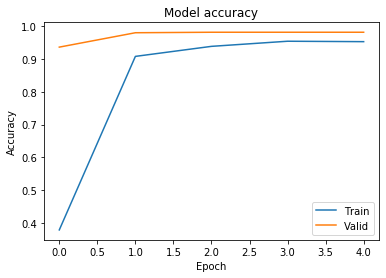

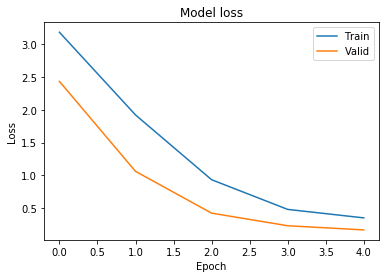

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.savefig('fe_plot.pdf')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


### Fine Tuning

In [24]:
num_base_layers = len(base_model.layers)
print("Number of layers in the base model:", num_base_layers)
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


Number of layers in the base model: 1039
0 input_1
1 stem_conv1
2 stem_bn1
3 activation
4 reduction_conv_1_stem_1
5 reduction_bn_1_stem_1
6 activation_1
7 activation_3
8 separable_conv_1_pad_reduction_left1_stem_1
9 separable_conv_1_pad_reduction_right1_stem_1
10 separable_conv_1_reduction_left1_stem_1
11 separable_conv_1_reduction_right1_stem_1
12 separable_conv_1_bn_reduction_left1_stem_1
13 separable_conv_1_bn_reduction_right1_stem_1
14 activation_2
15 activation_4
16 separable_conv_2_reduction_left1_stem_1
17 separable_conv_2_reduction_right1_stem_1
18 activation_5
19 separable_conv_2_bn_reduction_left1_stem_1
20 separable_conv_2_bn_reduction_right1_stem_1
21 separable_conv_1_pad_reduction_right2_stem_1
22 activation_7
23 reduction_add_1_stem_1
24 separable_conv_1_reduction_right2_stem_1
25 separable_conv_1_pad_reduction_right3_stem_1
26 activation_9
27 separable_conv_1_bn_reduction_right2_stem_1
28 separable_conv_1_reduction_right3_stem_1
29 separable_conv_1_reduction_left4_stem_1

In [0]:
# Un-freeze the top layers of the model
base_model.trainable = True

# Fine-tune from this layer onwards
#fine_tune_at = 974
#fine_tune_at = 1004
fine_tune_at = 1019
#fine_tune_at = 1038

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [26]:
# load extraction weights (in case of layer freezing number tuning)
model.set_weights(extraction_weights)

# compile the model reducing learning rate 
ft_opt = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
#ft_opt = tf.optimizers.Adam(learning_rate=0.0001)
#ft_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(optimizer=ft_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
len(model.trainable_variables)

22

In [27]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(batched_train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         verbose=1,
                         callbacks=[early_stopping],
                         validation_data=batched_val_ds,
                         steps_per_epoch=spe)

Train for 12.0 steps, validate for 6 steps
Epoch 5/10
12/12 [==============================] - 104s 9s/step - loss: 0.3155 - accuracy: 0.9499 - val_loss: 0.1651 - val_accuracy: 0.9818
Epoch 6/10
12/12 [==============================] - 61s 5s/step - loss: 0.3100 - accuracy: 0.9492 - val_loss: 0.1595 - val_accuracy: 0.9818
Epoch 7/10
12/12 [==============================] - 72s 6s/step - loss: 0.2962 - accuracy: 0.9557 - val_loss: 0.1537 - val_accuracy: 0.9818
Epoch 8/10
12/12 [==============================] - 72s 6s/step - loss: 0.2936 - accuracy: 0.9525 - val_loss: 0.1482 - val_accuracy: 0.9818
Epoch 9/10
12/12 [==============================] - 72s 6s/step - loss: 0.2849 - accuracy: 0.9583 - val_loss: 0.1431 - val_accuracy: 0.9818
Epoch 10/10
12/12 [==============================] - 72s 6s/step - loss: 0.2749 - accuracy: 0.9557 - val_loss: 0.1386 - val_accuracy: 0.9818


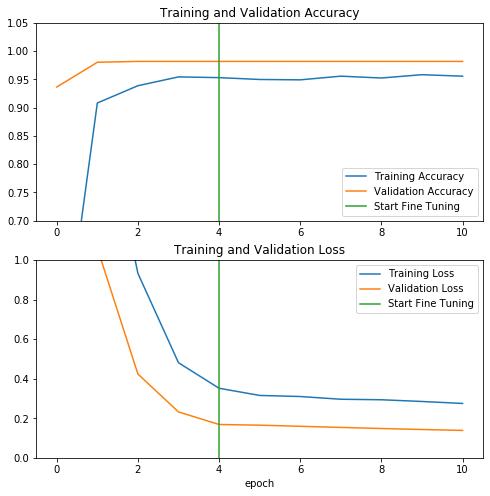

In [28]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1.05])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('plot.pdf')
plt.show()

# Validation Overview

In [29]:
loss, accuracy = model.evaluate(batched_val_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

6/6 [==============================] - 11s 2s/step - loss: 0.1386 - accuracy: 0.9818
Loss: 0.1386204995214939
Accuracy: 0.9818457


In [0]:
predictions = model.predict(batched_val_ds)

if verbose:
    print("Number of predictions:", len(predictions))
    print(predictions[0])
    print(np.argmax(predictions[0]))

In [0]:
def plot_batch_image(i, predictions_array, image_batch, label_batch):

    predictions_array = predictions_array[i]
    true_label = np.where(label_batch[i] == True)[0][0]
    img = image_batch[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image_batch[i])
  
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100 * np.max(predictions_array),
                                true_label),
                                color=color)
    plt.ylabel(CLASS_NAMES[label_batch[i] == True][0])


def plot_value_array(i, predictions_array, label_batch):
    predictions_array = predictions_array[i]
    true_label = np.where(label_batch[i] == True)[0][0]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(35), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

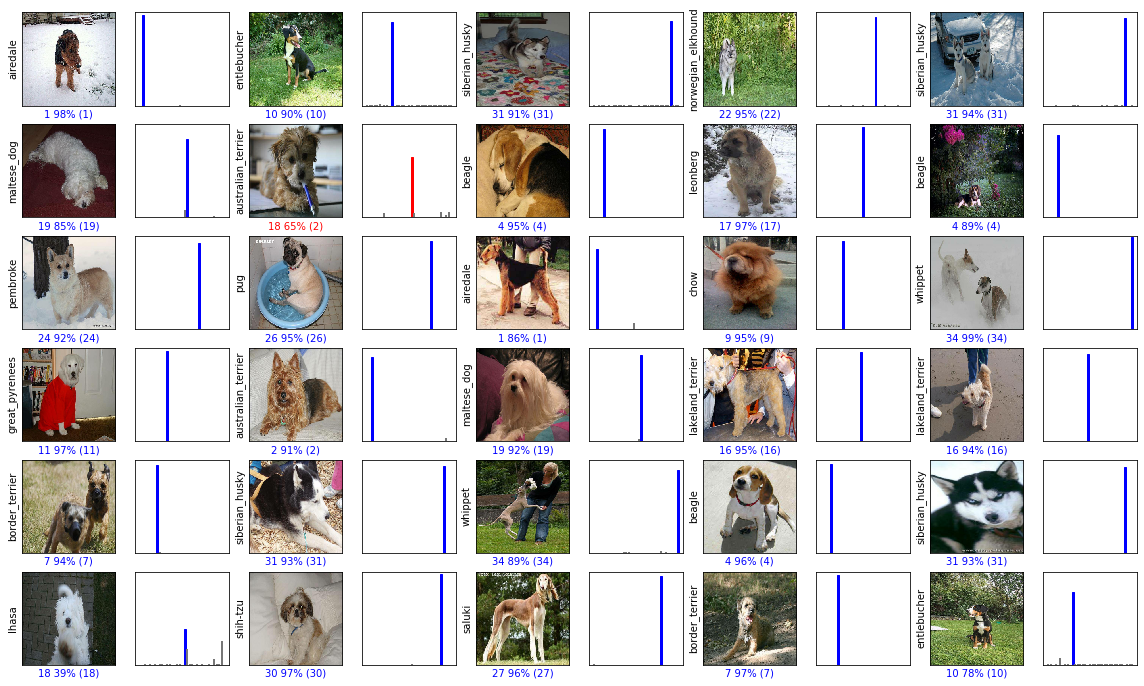

In [32]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 6
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
image_batch, label_batch = next(batched_val_ds.as_numpy_iterator())
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_batch_image(i, predictions, image_batch, label_batch)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, label_batch)
plt.show()

# Test Results

## Training on the entire dataset

In [0]:
training_ds = prepare_for_training(labeled_ds, cache='training_ds.tfcache')

# reinitialize the base model
base_model.set_weights(imagenet_weights)
base_model.trainable = False

test_model = tf.keras.Sequential([
                                  base_model,
                                  global_average_layer,
                                  #dropout_layer,
                                  #fc_layer,
                                  prediction_layer
                                  ])

test_model.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [34]:
spe = np.floor(image_count / BATCH_SIZE)

test_history = test_model.fit(training_ds,
                              epochs=initial_epochs,
                              verbose=1,
                              steps_per_epoch=spe
                              )

Train for 17.0 steps
Epoch 1/5
17/17 [==============================] - 105s 6s/step - loss: 0.2879 - accuracy: 0.9527
Epoch 2/5
17/17 [==============================] - 85s 5s/step - loss: 0.2399 - accuracy: 0.9554
Epoch 3/5
17/17 [==============================] - 85s 5s/step - loss: 0.2122 - accuracy: 0.9614
Epoch 4/5
17/17 [==============================] - 85s 5s/step - loss: 0.2015 - accuracy: 0.9554
Epoch 5/5
17/17 [==============================] - 83s 5s/step - loss: 0.2061 - accuracy: 0.9628


In [35]:
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

test_model.compile(optimizer=ft_opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                   )
print("Trainable variables:", len(model.trainable_variables))

Trainable variables: 22


In [36]:
test_model.fit(training_ds,
               epochs=total_epochs,
               initial_epoch=test_history.epoch[-1],
               verbose=1,
               steps_per_epoch=spe
               )

Train for 17.0 steps
Epoch 5/10
17/17 [==============================] - 92s 5s/step - loss: 0.1993 - accuracy: 0.9586
Epoch 6/10
17/17 [==============================] - 83s 5s/step - loss: 0.1977 - accuracy: 0.9600
Epoch 7/10
17/17 [==============================] - 85s 5s/step - loss: 0.1826 - accuracy: 0.9591
Epoch 8/10
17/17 [==============================] - 85s 5s/step - loss: 0.1857 - accuracy: 0.9623
Epoch 9/10
17/17 [==============================] - 85s 5s/step - loss: 0.1945 - accuracy: 0.9545
Epoch 10/10
17/17 [==============================] - 85s 5s/step - loss: 0.1895 - accuracy: 0.9554


##Load Test-Set

In [0]:
test_dir = "/content/drive/My Drive/dogs/Dataset/test"
test_dir = pathlib.Path(test_dir)

test_file_list = list(test_dir.glob('*.jpg'))

test_image_count = len(test_file_list)
if verbose: print("Number of test images:", test_image_count)

In [0]:
list_ds_test = tf.data.Dataset.list_files(str(test_dir/'*'))
# cache to save prediction ordering
list_ds_test = list_ds_test.cache("list_ds_test.tfcache")

# cache check
if verbose:
    for f in list_ds_test.take(4):
        print(f.numpy())
    print("\n")
    for f in list_ds_test.take(4):
        print(f.numpy())

In [0]:
def process_test_path(file_path):
    # load raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [0]:
test_ds = list_ds_test.map(process_test_path, num_parallel_calls=AUTOTUNE)

if verbose:
    for image in test_ds.take(1):
        #print("Image tensor:", image)
        print("Image shape:", image.numpy().shape)

In [0]:
batched_test_ds = test_ds.batch(BATCH_SIZE).cache('./dogs-test.tfcache')

## Predictions

In [42]:
test_predictions = test_model.predict(batched_test_ds)
#test_predictions = model.predict(batched_test_ds)

print("Number of predictions:", len(test_predictions))
print(test_predictions[0])
print(np.argmax(test_predictions[0]))

Number of predictions: 945
[1.4877750e-04 5.7882407e-05 9.8352430e-05 8.1618797e-05 1.2304552e-04
 1.7424650e-04 2.0209383e-03 8.8978668e-05 1.0002051e-04 1.2096875e-04
 1.5597965e-04 8.3722465e-05 8.6095301e-05 1.0222149e-04 5.2426771e-05
 9.9232692e-01 1.4922681e-04 1.0405924e-04 1.4287284e-04 2.0534270e-04
 1.6091071e-04 2.3687196e-04 8.0152960e-05 1.1617026e-03 1.3423199e-04
 2.5948742e-04 1.3795512e-04 1.3675592e-04 1.9777694e-04 1.0300494e-04
 3.7161296e-04 1.3461812e-04 7.5194272e-05 3.2980164e-04 5.6322686e-05]
15


In [43]:
f = open("test_results.csv", "w")
i = 0
f.write("id,breed\n")
for img_file in list_ds_test.as_numpy_iterator():
    img_id = str(img_file).split(os.path.sep)[-1][:-5]
    img_prediction = CLASS_NAMES[np.argmax(test_predictions[i])]
    i += 1
    f.write(img_id + "," + img_prediction + "\n")
print("predicion lines written:", i)
f.close()

predicion lines written: 945
